1. Reading the files
2. Translating russian names to english
3. Data Exploration
4. Summarizing and check for patterns
5. Identifying outliers


In [1]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import datetime
from googletrans import Translator
from langdetect import detect

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')

sales = pd.read_csv("./data/sales_train_v2.csv",
                    parse_dates=['date'], date_parser = dateparse)

sales['YearMonth']=sales['date'].map(lambda x: 100*x.year + x.month)

In [3]:
sales['shop_id'].unique()

array([59, 25, 24, 23, 19, 22, 18, 21, 28, 27, 29, 26,  4,  6,  2,  3,  7,
        0,  1, 16, 15,  8, 10, 14, 13, 12, 53, 31, 30, 32, 35, 56, 54, 47,
       50, 42, 43, 52, 51, 41, 38, 44, 37, 46, 45,  5, 57, 58, 55, 17,  9,
       49, 39, 40, 48, 34, 33, 20, 11, 36], dtype=int64)

In [4]:
#Taking a quick peak into the table
sales.head()
#sales['item_id'].unique()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,YearMonth
0,2013-01-02,0,59,22154,999.00,1.0,201301
1,2013-01-03,0,25,2552,899.00,1.0,201301
2,2013-01-05,0,25,2552,899.00,-1.0,201301
3,2013-01-06,0,25,2554,1709.05,1.0,201301
4,2013-01-15,0,25,2555,1099.00,1.0,201301


In [5]:
print('\n Description of the table \n')
display(sales.describe())

print('\n Columns types in the table \n')
display(sales.dtypes)


 Description of the table 



,date_block_num,shop_id,item_id,item_price,item_cnt_day,YearMonth
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,2.013839e+05
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,7.645367e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,2.013010e+05
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.013080e+05
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,2.014030e+05
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,2.014120e+05
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,2.015100e+05



 Columns types in the table 



date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
YearMonth                  int64
dtype: object

In [6]:
#DeSize DataFrame

def desize(df):
    flt_cols = [i for i in df if df[i].dtype == "float64"]
    int_cols = [i for i in df if df[i].dtype in ["int64"]]
    df[flt_cols] = df[flt_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

sales = desize(sales)
sales.dtypes

date              datetime64[ns]
date_block_num             int16
shop_id                    int16
item_id                    int16
item_price               float32
item_cnt_day             float32
YearMonth                  int16
dtype: object

In [7]:
#Reading other supporting files

item_categories = pd.read_csv("./data/item_categories.csv")

# item_categories['item_category_id'].unique()
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
#Translating russian category name to english
translator = Translator()

# item_categories['item_category_name_eng'] = item_categories['item_category_name'].map(lambda x: translator.translate(x, src="ru", dest="en").text)
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
# item_categories.to_csv('item_categories_translated.csv')

In [10]:
#Reading other supporting files

items = pd.read_csv("./data/items.csv")
# items['item_category_id'].unique()
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
#Reading other supporting files

shops = pd.read_csv("./data/shops.csv")
# shops['shop_id'].unique()
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
# translator = Translator()

# shops['shop_name_eng'] = shops['shop_name'].map(lambda x: translator.translate(x, src="ru", dest="en").text)
# shops.head()

In [13]:
# items.to_csv('shops_translated.csv')

In [14]:
#Adding item_category to sales table

sales_item_cat = pd.merge(sales, items[['item_id', 'item_category_id']], on = ['item_id'], how = 'inner')
sales_item_cat.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,YearMonth,item_category_id
2935844,2015-10-17,33,25,8428,249.0,1.0,4902,40
2935845,2015-10-01,33,25,7903,12198.0,1.0,4902,15
2935846,2015-10-29,33,25,7610,2890.0,1.0,4902,64
2935847,2015-10-22,33,25,7635,2100.0,1.0,4902,64
2935848,2015-10-01,33,25,7640,4040.0,1.0,4902,64


Let's see the sales distribution by item categories

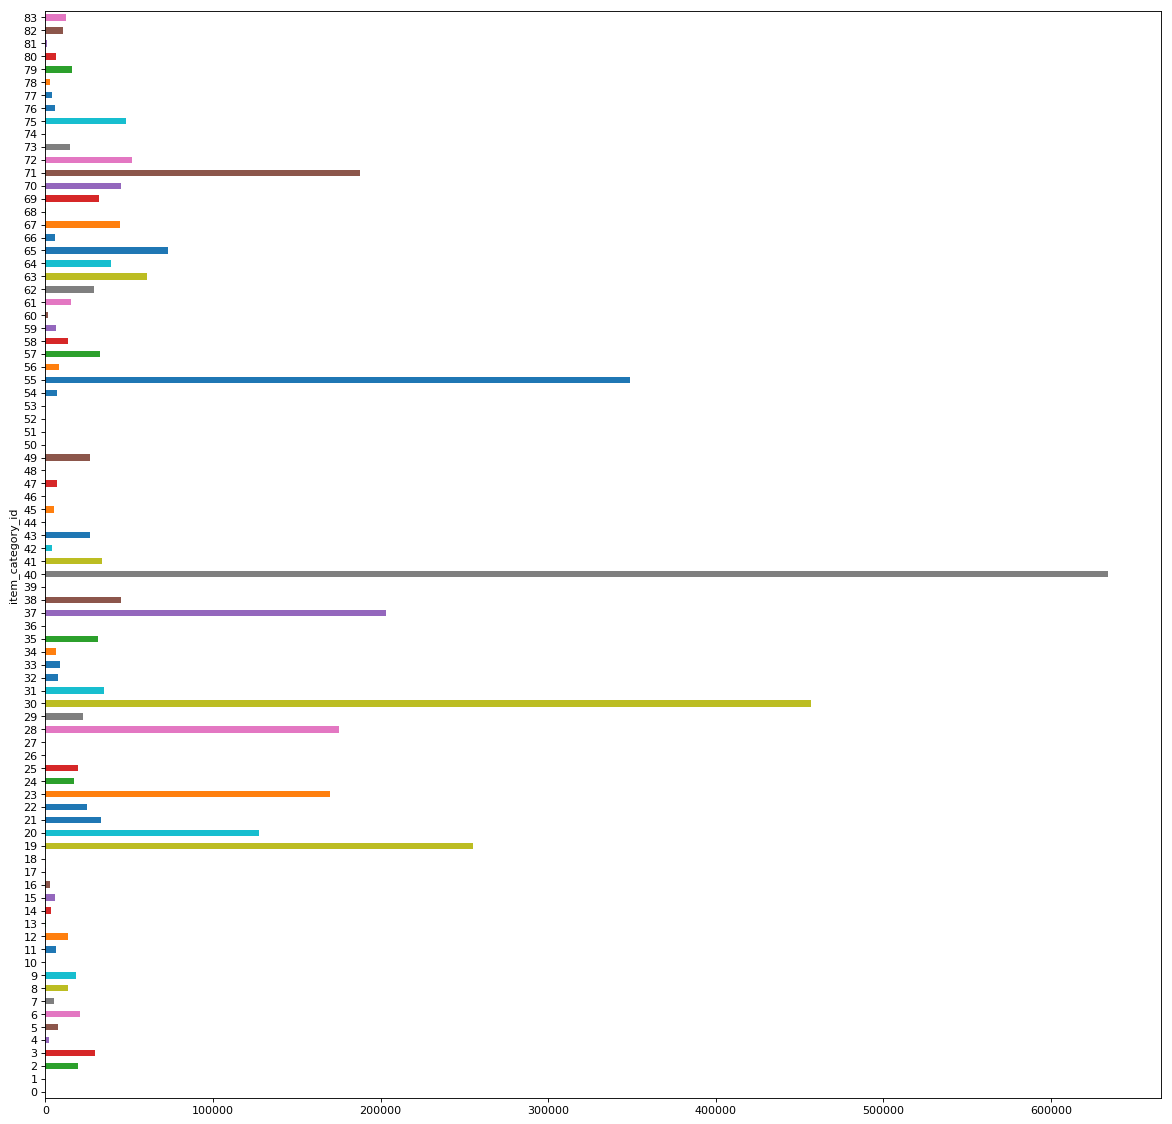



Here are top 5 most selling item categories


,item_category_id,item_cnt_day
40,40,634171.0
30,30,456540.0
55,55,348591.0
19,19,254887.0
37,37,203284.0




 Here are top 5 least selling items categories


,item_category_id,item_cnt_day
50,50,3.0
0,0,3.0
1,1,2.0
10,10,1.0
51,51,1.0


In [15]:
figure(num=None, figsize=(18, 18), dpi=80, facecolor='w', edgecolor='k')

sale_by_category = sales_item_cat[['item_category_id', 'item_cnt_day']].groupby(['item_category_id'])['item_cnt_day'].agg('sum')
sale_by_category.plot.barh(x = 'item_category_id', y = 'item_cnt_day')
plt.show()

#Top 5 selling and non selling items
print('\n\nHere are top 5 most selling item categories')

sale_by_category_srt = pd.DataFrame(sale_by_category).reset_index().sort_values(by=['item_cnt_day'], ascending = False)
display(sale_by_category_srt.head())

print('\n\n Here are top 5 least selling items categories')
display(sale_by_category_srt.tail())

There seems a big range of difference in the amount of minimum selling item and most selling items. I think it would be a good idea to explore the varity of products on the basis of amount of sales.

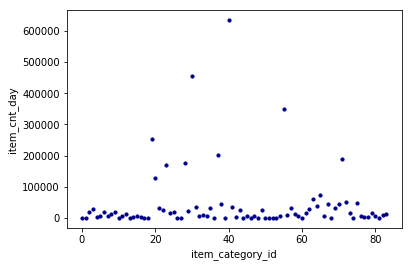

In [16]:
sale_by_category_srt.plot.scatter(x = 'item_category_id', y = 'item_cnt_day', color='DarkBlue', s =10)
plt.show()

The inflated scale is due to few high lying data points, let's see the distribution for items sold < 100000

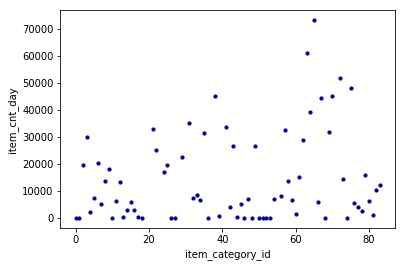

In [17]:
sale_by_category_srt[sale_by_category_srt['item_cnt_day'] < 100000].plot.scatter(x = 'item_category_id', y = 'item_cnt_day', color='DarkBlue', s =10)

Distribution is much better here but there are quite visible difference in the amount of item categories sold which can range from **High volume (> 100000), medium volume (100000 to 10000) and low volume (< 10000)**. I would like to do more analysis on these data points to understand the various clusters. But before we move on to that I would like to understand the distribution by number of items per categories.

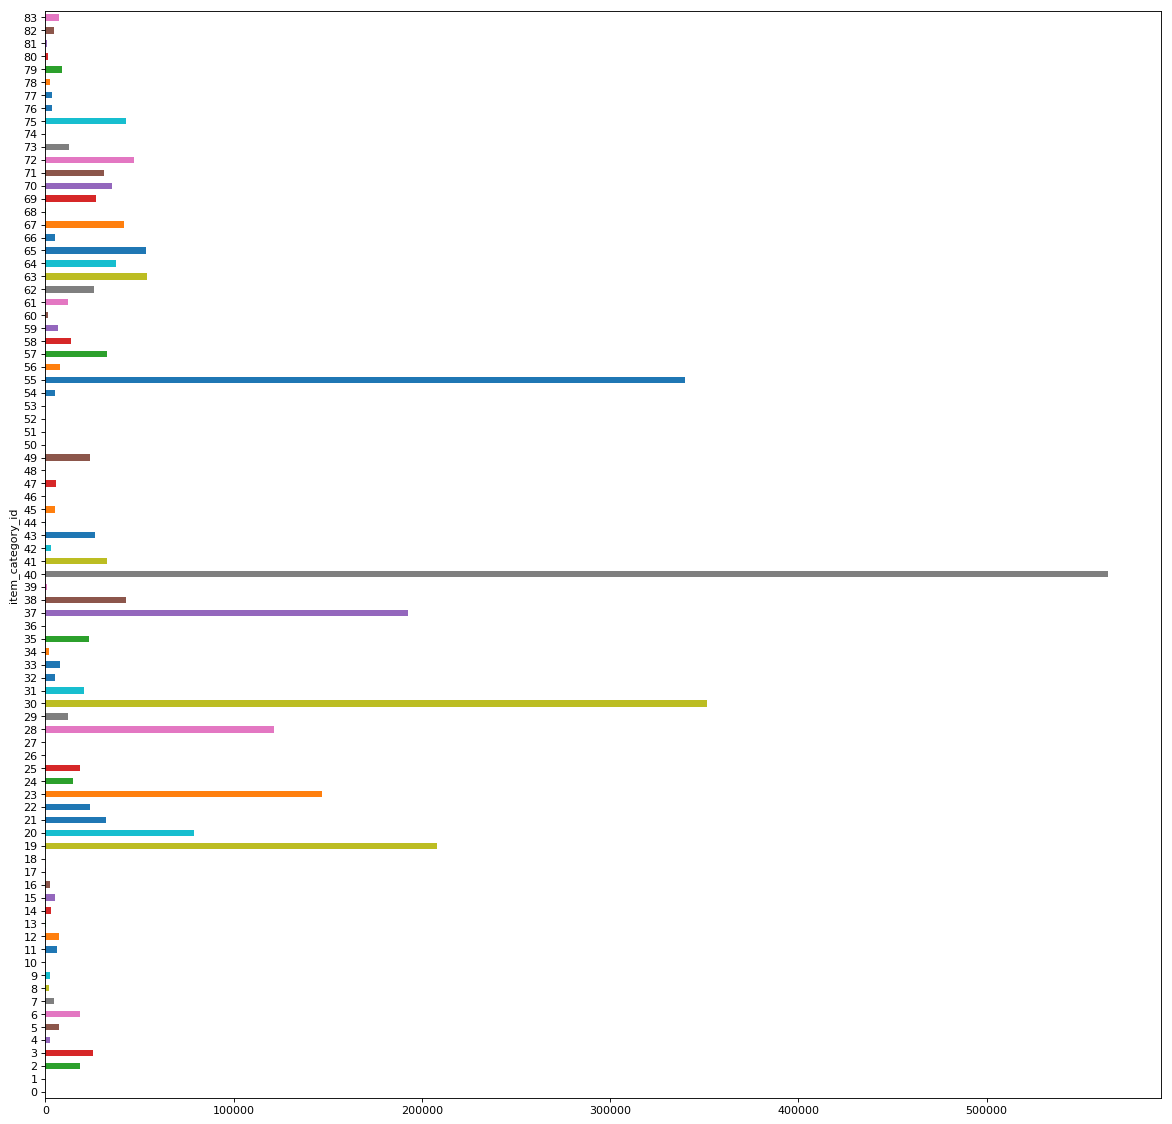

,item_category_id,item_id
40,40,564652
30,30,351591
55,55,339585
19,19,208219
37,37,192674


,item_category_id,item_id
51,51,1
10,10,1
1,1,2
50,50,2
0,0,3


In [18]:
figure(num=None, figsize=(18, 18), dpi=80, facecolor='w', edgecolor='k')

item_by_category = sales_item_cat[['item_category_id', 'item_id']].groupby(['item_category_id'])['item_id'].agg('count')
item_by_category.plot.barh(x = 'item_category_id', y = 'item_id')
plt.show()

display(pd.DataFrame(item_by_category.reset_index().sort_values(by=['item_id'], ascending = False)).head())
display(pd.DataFrame(item_by_category.reset_index().sort_values(by=['item_id'])).head())

Quite apparent the category with more items is having more sale. Lets validate it calculating correlation coefficient.

In [19]:
item_sales_by_category = sales_item_cat[['item_category_id', 'item_cnt_day', 'item_id']].groupby(['item_category_id']).agg({'item_id' :'count', 'item_cnt_day' : 'sum'}).reset_index()
item_sales_by_category.corr()

,item_category_id,item_id,item_cnt_day
item_category_id,1.000000,-0.025436,-0.017441
item_id,-0.025436,1.000000,0.981040
item_cnt_day,-0.017441,0.981040,1.000000


Let's **Conclude** this part our analysis here with a finding that more the number of items in a category more the total sales for that category. Thus item category is not a feature we should consider further.

Now, lets Analyse the significance of price to the item sales

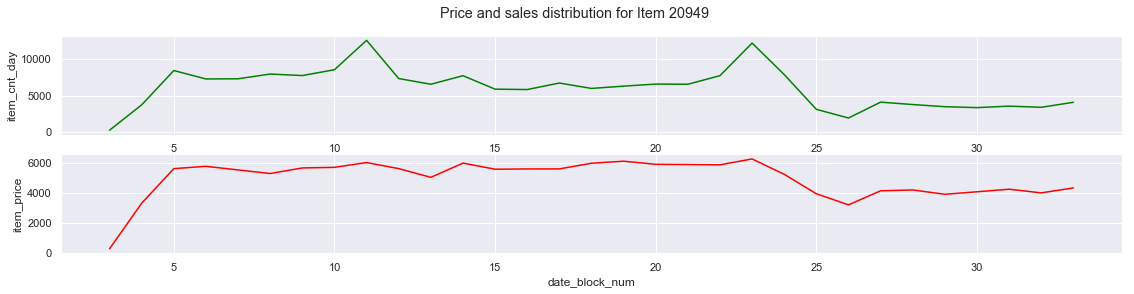

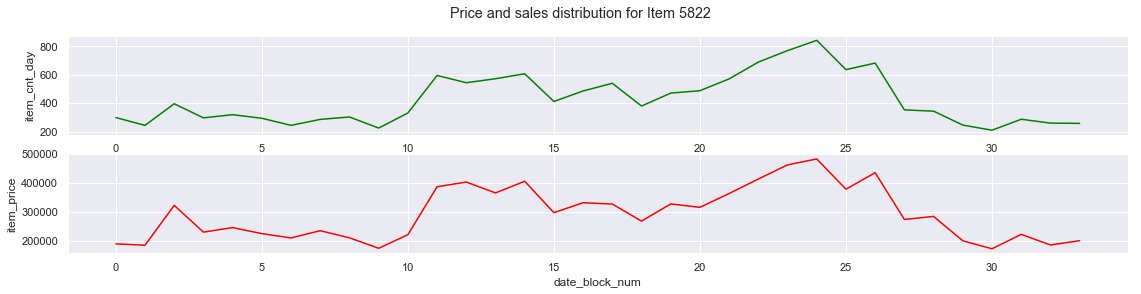

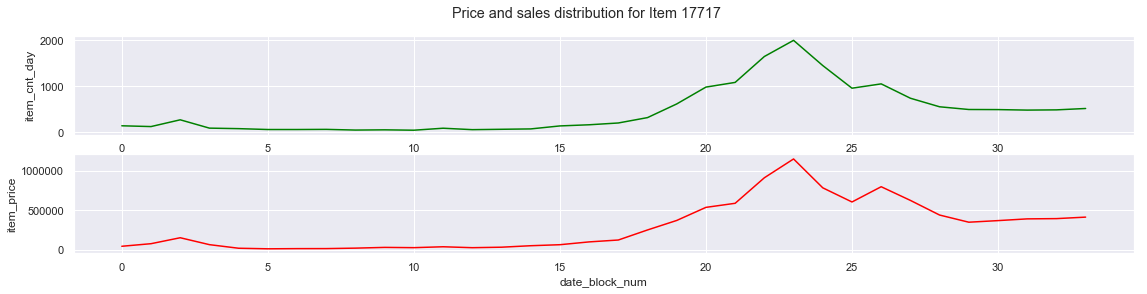

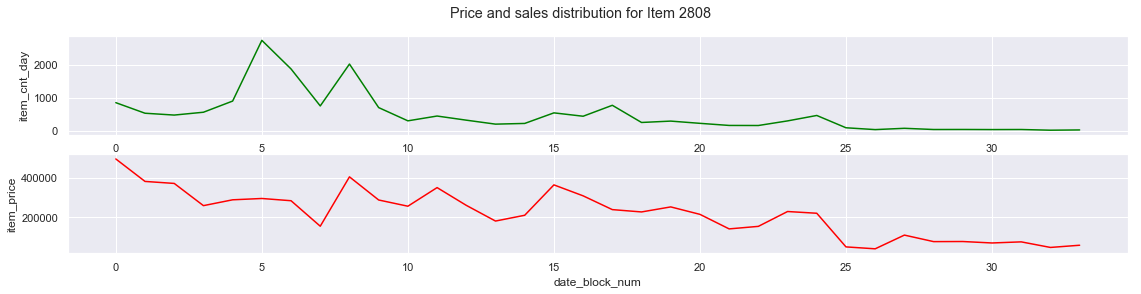

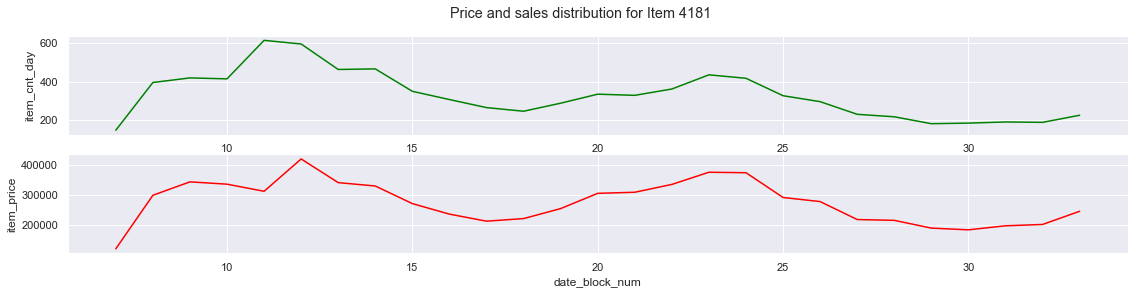

In [20]:
#Get the top five selling items
tp5itms = sales['item_id'].value_counts()[:5].index

for i in tp5itms:
    d = sales[sales['item_id'] == i][['date_block_num','item_cnt_day','item_price']].groupby(['date_block_num'])['item_cnt_day','item_price'].agg('sum').reset_index()
    sns.set(rc={'figure.figsize':(19,4)})
    fig, ax =plt.subplots(2,1)
    fig.suptitle('Price and sales distribution for Item {}'.format(i))
    sns.lineplot(x='date_block_num', y='item_cnt_day', data=d, ax = ax[0], color = 'green')
    sns.lineplot(x='date_block_num', y='item_price', data=d, ax = ax[1], color="red")
    fig.show

What these graph suggest, the price of an item and sales are propositional and the item sales jumps up during the end of the years.

In next set of steps we will work on few options to reduce the rows in the data by identifying the un-operational shops and  discontinued items i.e. the shops / items which does not have any activities for a period of one year.

The reason I am looking at 1 year period is because there can be some shops / items those are seasonal and are those shops are open only once a year or items sold only once a year.

In [21]:
# sales.head()
sales_by_shop_id = sales.pivot_table(index=['shop_id'],values=['item_cnt_day'], columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

In [22]:
inoperative_shops = sales_by_shop_id[sales_by_shop_id[(sales_by_shop_id.columns[-12:])].sum(axis=1) == 0]['shop_id'].tolist()
print('Here is a list of shops id inoperative for past 12 months {}'.format(inoperative_shops))

Here is a list of shops id inoperative for past 12 months [0, 1, 8, 13, 23, 32]


In [23]:
sales_by_item_id = sales.pivot_table(index=['item_id'],values=['item_cnt_day'], columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

In [24]:
discontinued_items = sales_by_item_id[sales_by_item_id[(sales_by_item_id.columns[-12:])].sum(axis=1) == 0]['item_id'].tolist()

print('Out of total {}'.format(len(sales_by_item_id)) + ' items there are {} obsolete items.'.format(len(discontinued_items)))

Out of total 21807 items there are 9638 obsolete items.


Since these 9638 items had 0 sales for past one year, so it should be safe to assume sales for next month will be 0. We are going to impute this 0 value in our predicted result for these items.

From dataset **sales** lets remove obsolete shops and items

In [25]:
#clear some memory

del sale_by_category_srt
del item_sales_by_category
del sales_by_item_id
del sales_by_shop_id
gc.collect()

41047

In [26]:
sales_limited = sales[~sales['shop_id'].isin(inoperative_shops)]
sales_limited = sales[~sales['item_id'].isin(discontinued_items)]
sales_limited.shape

(2462855, 7)

In next set of steps let's try to identify the outliers in terms of number of items sold and price.

In [27]:
price_distribution_item = sales_limited[['item_id', 'item_price']].groupby('item_id')['item_price'].describe()[['mean', 'count', '25%', '50%', '75%', 'std']]
price_distribution_item = price_distribution_item.reset_index()
price_distribution_item.head()

,item_id,mean,count,25%,50%,75%,std
0,2,58.0,2.0,58.0,58.0,58.0,0.0
1,5,28.0,1.0,28.0,28.0,28.0,NaN
2,7,28.0,1.0,28.0,28.0,28.0,NaN
3,10,28.0,1.0,28.0,28.0,28.0,NaN
4,11,58.0,1.0,58.0,58.0,58.0,NaN


In [28]:
sale_distribution_item = pd.merge(sales_limited, price_distribution_item, on = 'item_id', how = 'left')
sale_distribution_item = desize(sale_distribution_item)

In [29]:
gc.collect()

481

In [30]:
def outliers(df):
    if df['25%'] - 1.5 * (df['75%'] - df['25%']) > df['item_price']:
        return 1
    elif df['75%'] + 1.5 * (df['75%'] - df['25%'])  < df['item_price']:
        return 1
    else:
        return 0

# price_outliers = sale_distribution_item.assign(outl = sale_distribution_item.apply(outliers, axis = 1))

price_sale_distribution = sale_distribution_item

#Flag outlier on the basis of Quartile ranges - IQR
price_sale_distribution['outlier'] = np.where(((sale_distribution_item['25%'] - 1.5 * (sale_distribution_item['75%'] - sale_distribution_item['25%']) > sale_distribution_item['item_price']) & (sale_distribution_item['item_price'] < sale_distribution_item['mean'])) | ((sale_distribution_item['75%'] + 1.5 * (sale_distribution_item['75%'] - sale_distribution_item['25%']) < sale_distribution_item['item_price']) & ((sale_distribution_item['item_price'] > sale_distribution_item['mean']))), 1, 0)

#Flag outlier on the basis of standard deviation - Z-score
price_sale_distribution['outlier_std'] = np.where(((sale_distribution_item['mean'] + 2 * sale_distribution_item['std'] < sale_distribution_item['item_price']) & (sale_distribution_item['item_price'] > sale_distribution_item['mean']) | (sale_distribution_item['mean'] - 2 * sale_distribution_item['std'] > sale_distribution_item['item_price']) & (sale_distribution_item['item_price'] < sale_distribution_item['mean'])), 1, 0)

In [31]:
imputed_sales_price = price_sale_distribution.query('outlier == 1 & outlier_std == 1')
imputed_sales_price.shape

(98251, 15)

There are **98251** records calculated as outliers using IQR and Z-score, Imputing the median price values for these outliers

In [32]:
non_imputed_sales_price = price_sale_distribution.query('outlier != 1 | outlier_std != 1')
non_imputed_sales_price.shape

(2364604, 15)

In [33]:
imputed_sales_price.loc['item_price'] = imputed_sales_price['50%']
imputed_sales_price.head()

c:\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,YearMonth,mean,count,25%,50%,75%,std,outlier,outlier_std
17,2013-01-02,0.0,25.0,2719.0,2699.0,1.0,4693.0,923.673950,382.0,749.0,749.0,749.000000,426.967529,1.0,1.0
18,2013-01-12,0.0,25.0,2719.0,2699.0,1.0,4693.0,923.673950,382.0,749.0,749.0,749.000000,426.967529,1.0,1.0
20,2013-01-30,0.0,25.0,2720.0,1699.0,1.0,4693.0,819.687195,289.0,749.0,749.0,749.000000,310.130127,1.0,1.0
30,2013-01-16,0.0,25.0,2833.0,599.0,1.0,4693.0,353.906464,1690.0,299.0,299.5,312.540009,113.462288,1.0,1.0
31,2013-01-19,0.0,25.0,2833.0,599.0,1.0,4693.0,353.906464,1690.0,299.0,299.5,312.540009,113.462288,1.0,1.0


In [34]:
imputed_sales = pd.concat([non_imputed_sales_price, imputed_sales_price])
imputed_sales.shape

(2462856, 15)

In [21]:
def cast(df, key, value, join_how='outer'):
    """Casts the input data frame into a tibble,
    given the key column and value column.
    """
    assert type(df) is pd.DataFrame
    assert key in df.columns and value in df.columns
    assert join_how in ['outer', 'inner']
    
    fixed_vars = df.columns.difference([key, value])
    tibble = pd.DataFrame(columns=fixed_vars) # empty frame
    
    new_vars = df[key].unique()
    for c in new_vars:
        df_v = df[df[key] == c]
        del df_v[key]
        df_v = df_v.rename(columns = {value:c})       
        tibble = tibble.merge(df_v, on=list(fixed_vars), how=join_how)
    return tibble

def melt(df, col_vals, key, value):
    assert type(df) is pd.DataFrame
    keep_vars = df.columns.difference(col_vals)
    melted_sections = []
    for c in col_vals:
        melted_c = df[keep_vars].copy()
        melted_c[key] = c
        melted_c[value] = df[c]
        melted_sections.append(melted_c)
    melted = pd.concat(melted_sections)
    return melted

In [120]:
# shop_59 = sales[sales.shop_id == 59].groupby(['shop_id', 'item_id', 'date_block_num']).agg({ 'item_cnt_day' : 'sum'}).sort_values(['date_block_num'])
Item_grp = sales.groupby(['item_id', 'date_block_num']).agg({ 'item_cnt_day' : 'sum'})

Item_grp_df = Item_grp.add_suffix('_Count').reset_index()

# shop_59_df.columns
Item_grp_flat = cast(Item_grp_df, 'date_block_num', 'item_cnt_day_Count').fillna(0)
Item_grp_flat[34] = 0
Item_long = melt(Item_grp_flat, col_vals = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34], key = 'month',  value = 'sales')
Item_long = Item_long.sort_values(['item_id','month'])

In [131]:
Item_long_4161 = Item_long[Item_long.item_id == 4]

Item_long_4161.set_index('month',inplace=True)
Item_long_4161.index.freq = 'MS'

train, test = Item_long_4161.iloc[:34, 1], Item_long_4161.iloc[34:, 1]
model = ExponentialSmoothing(train, trend = 'add',  seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

In [135]:
sales[sales.item_id == 4]
Item_long_4161

,item_id,sales
month,,
0,4,0.0
1,4,0.0
2,4,0.0
3,4,0.0
4,4,0.0
5,4,0.0
6,4,0.0
7,4,0.0
8,4,0.0


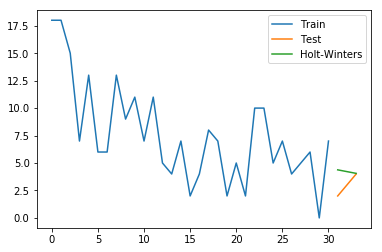

In [112]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

In [22]:
shop_59_flat.columns

Index(['shop_id', 'item_id',         0,         1,         2,         3,
               4,         5,         6,         7,         8,         9,
              10,        11,        12,        13,        14,        15,
              16,        17,        18,        19,        20,        21,
              22,        23,        24,        25,        26,        27,
              28,        29,        30,        31,        32,        33],
      dtype='object')

In [111]:
model = ExponentialSmoothing(shop_59_df, trend='add', seasonal='add', seasonal_periods=12, damped = True).fit(use_boxcox=True)

ValueError: Data must be positive.

In [47]:
d1 = sales_sum[sales_sum["item_id"] == 59][['date','item_cnt_day']]
d1['item_cnt_day'] = d1['item_cnt_day'].astype(int)
d1.set_index('date', inplace = True)
d1.index.freq = 'MS'

d1train, d1test = d1.iloc[:32, 0], d1.iloc[32:, 0]
d1train
#model = ExponentialSmoothing(d1train, seasonal='add', seasonal_periods=12, missing = True).fit()

#pred = model.predict(start=d1test.index[0], end=d1test.index[-1])
#pred



#d2 = pd.DataFrame(h, columns = ['date','item_cnt_day'])
#d2.set_index('date', inplace = True)
 
#d2 = pd.DataFrame(columns=['item_cnt_day'], index=pd.to_datetime([]))
#d2.loc[pd.Timestamp('2015-11-01')] = pd.Series([0], ['item_cnt_day'])
#d2[["item_cnt_day"]].apply(pd.to_numeric)
#d2.dtypes

#d1['month_year'] = pd.to_datetime(d1.month_year.astype(str).str.slice(0,4)+d1.month_year.astype(str).str.slice(5,7),format = '%y%m')
#d1.plot.line(x = 'month_year', y = 'item_cnt_day')
#pd.datetime(d1['month_year'])
#df['date'] = pd.to_datetime(df[['year','month']].assign(day=1)).dt.to_period('M')

date
2013-01-01    18
2013-02-01    18
2013-03-01    15
2013-04-01     7
2013-05-01    13
2013-06-01     6
2013-07-01     6
2013-08-01    13
2013-09-01     9
2013-10-01    11
2013-11-01     7
2013-12-01    11
2014-01-01     5
2014-02-01     4
2014-03-01     7
2014-04-01     2
2014-05-01     4
2014-06-01     8
2014-07-01     7
2014-08-01     2
2014-09-01     5
2014-10-01     2
2014-11-01    10
2014-12-01    10
2015-01-01     5
2015-02-01     7
2015-03-01     4
2015-04-01     5
2015-05-01     6
2015-07-01     7
2015-08-01     2
2015-09-01     3
Name: item_cnt_day, dtype: int32

In [24]:
#fit1 = ExponentialSmoothing(d1, seasonal_periods=12, trend='add', seasonal='add', missing = True).fit()
model = ExponentialSmoothing(d1, seasonal='add', seasonal_periods=12).fit()


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [76]:

#Item_trend = sales.pivot_table(index = ['item_id'], columns = ['month_year'], values = 'item_cnt_day', aggfunc = np.sum).fillna(0)
#train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
#Item_trend[Item_trend.index.get_level_values('item_id') == 0]
#Item_trend
#Item_trend.reset_index(inplace=True)
#Item_trend[Item_trend["item_id"] == 59]#.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)

month_year,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,...,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
59,59,16.0,15.0,7.0,5.0,13.0,10.0,14.0,14.0,13.0,...,3.0,3.0,6.0,0.0,7.0,4.0,7.0,3.0,0.0,0.0


In [54]:
l